In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Helper Functions

In [118]:
def add_noise(df, scale):
    noise = pd.DataFrame(np.random.normal(loc=0, scale=scale, size=df.shape), columns=df.columns)

    df_noisy = noise.add(df)

    return df_noisy

In [119]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

# Prepare Data

In [120]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [121]:
# scale spectrum data
data_scale = 10**12
spectrum_train = spectrum_train.multiply(data_scale)
spectrum_test = spectrum_test.multiply(data_scale)

In [122]:
from sklearn.model_selection import train_test_split
# set train and test data

# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 0

# use only if split == 1
# 1 - combine given training and validation data
# 0 - use only training data
combine = 0

# 1 - noise added to training data
# 0 - no noise added
noise_scale = 0.01
noise = 1

if noise:
    if direction:
        temp_train = add_noise(temp_train, noise_scale)
    else:
        spectrum_train = add_noise(spectrum_train, noise_scale)

if not combine:
    if direction:
        X_train = temp_train
        X_test = temp_test
        y_train = spectrum_train
        y_test = spectrum_test
    else:
        X_train = spectrum_train
        X_test = spectrum_test
        y_train = temp_train
        y_test = temp_test
else:
    spectrum = pd.concat([spectrum_train, spectrum_test], axis=0)
    temp = pd.concat([temp_train, temp_test], axis=0)
    if direction:
        X_train, X_test, y_train, y_test = train_test_split(temp, spectrum, test_size=0.3, random_state=101)
    else:
        X_train, X_test, y_train, y_test = train_test_split(spectrum, temp, test_size=0.3, random_state=101)

In [123]:
# create input and output tensors
X = df_to_tensor(X_train)
y = df_to_tensor(y_train)

In [124]:
n_samples, input_size = X.shape
_, output_size = y.shape

In [125]:
input_size

66

# Design Model 
(input size, output size, forward pass)

In [126]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [127]:
model = NeuralNetRegressor(
    module=Net,
    module__input_size=input_size,
    module__output_size=output_size,
    optimizer=torch.optim.Rprop,
    criterion=nn.MSELoss,
    max_epochs=5000,
    verbose=0
)

param_grid = {
    'module__hidden_units': [30, 45, 60],
    'optimizer__lr': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3)

# Training Loop

In [128]:
grid_search.fit(X, y)

In [ ]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [ ]:
pred = pd.DataFrame(best_model.predict(df_to_tensor(X_test)))
mse = mean_squared_error(y_test, pred)
print(f'Mean Squared Error of the Best Model: {mse}')

Mean Squared Error of the Best Model: 203.94995705119365


# Plots

### Clean

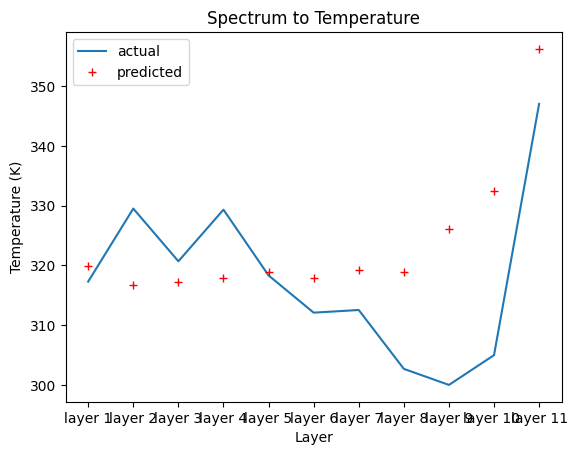

In [ ]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(pred))

actual_np = y_train.values[index]
pred_np = pred.values[index]


plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

if direction:
    plt.title("Temperature to Spectrum")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Spectrum to Temperature")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()

### Noisy

In [ ]:
noisy_test = add_noise(X_test, 0.01)

pred = pd.DataFrame(best_model.predict(df_to_tensor(noisy_test)))

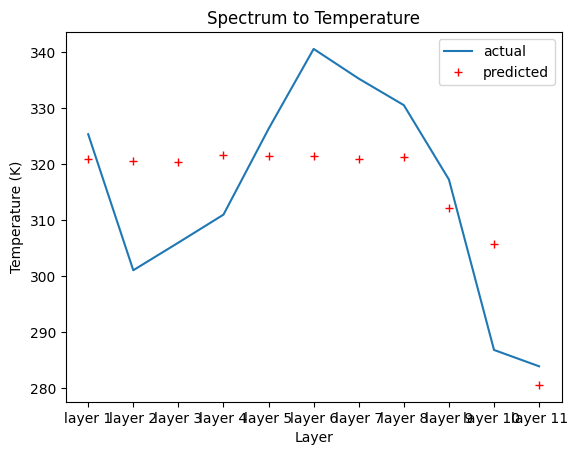

In [ ]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(pred))

actual_np = y_test.values[index]
pred_np = pred.values[index]


plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

if direction:
    plt.title("Temperature to Spectrum")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Spectrum to Temperature")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()